In [2]:
from MITgcmutils.utils import writebin
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from ocean_utils import *
nx = 174   # gridpoints in x
ny = 36    # gridpoints in y
nz = 10    # gridpoints in z

dx = 1     # grid spacing in x (degrees longitude)
dy = 1     # grid spacing in y (degrees latitude)
x0 = 118     # origin in x,y for ocean domain
y0 = -18    # (i.e. southwestern corner of ocean domain)
x1 = x0 + (nx-1)*dx    # origin in x,y for ocean domain
y1 = y0 + (ny-1)*dy    # (i.e. southwestern corner of ocean domain)

opath = '../input/'

#ipath = '/mnt/d/project/IAVNNG/Data/'
ipath = '../../IAVNNG/data/'
# input files
fbath = ipath + 'GLO-MFC_001_030_mask_bathy.nc'
fclim = ipath + 'cmems_climatology_mon.nc'
fwind = ipath + 'era5_tau_mon.nc'
fwlsm = ipath + 'era5_lsm.nc'

inc = round(dx*12)
winc = round(dx*4)

## 生成海表面风应力场 （Agrid）

(12, 36, 174)


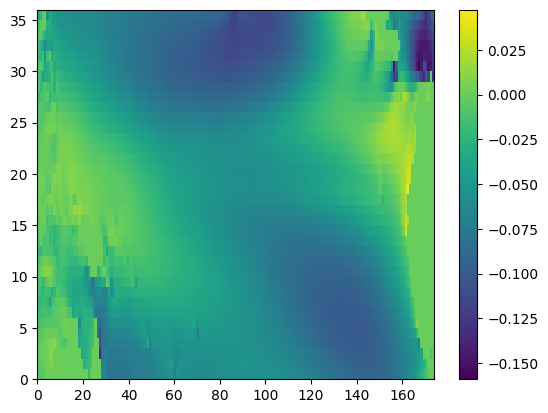

In [2]:
isclim = True
wedge = 3
ds = xr.open_dataset(fwind)
dsm = xr.open_dataset(fwlsm)
dss = ds.sel(valid_time=slice('2000-01', '2019-12'))

taux = dss['ewss'].loc[:,y0-wedge:y1+wedge:-1,x0-wedge:x1+wedge].load()
tauy = dss['nsss'].loc[:,y0-wedge:y1+wedge:-1,x0-wedge:x1+wedge].load()
lsm  = dsm['lsm'].loc[y0-wedge:y1+wedge:-1,x0-wedge:x1+wedge].load()
if isclim:
    taux = taux.groupby('valid_time.month').mean('valid_time')
    tauy = tauy.groupby('valid_time.month').mean('valid_time')
taux.values = gsmooth2d(taux.values, sigma=winc/3, mask=lsm<0.5, threshold=0.1,fill_value=0)
tauy.values = gsmooth2d(tauy.values, sigma=winc/3, mask=lsm<0.5, threshold=0.1,fill_value=0)
taux = taux.loc[:,y0:y1:winc,x0:x1:winc]
tauy = tauy.loc[:,y0:y1:winc,x0:x1:winc]
taux, tauy = taux.values, tauy.values

taux, tauy = taux/86400, tauy/86400  # era5提供的风应力是一天的积分，需要除以86400转换为风应力
plt.pcolormesh(taux.mean(0))
plt.colorbar()
print(taux.shape)
# # 保存为MITgcm驱动所需的二进制文件
writebin(opath+'taux.bin',taux)
writebin(opath+'tauy.bin',tauy)

## 生成地形数据
---
需注意水深取负值，且将陆地填补为0

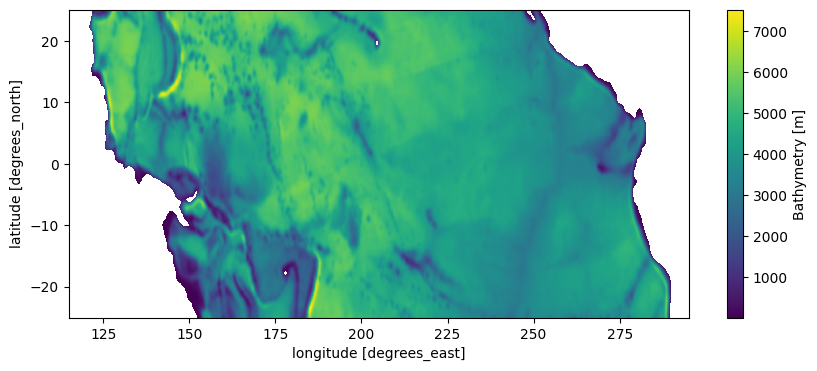

(601, 2161) (36, 174)


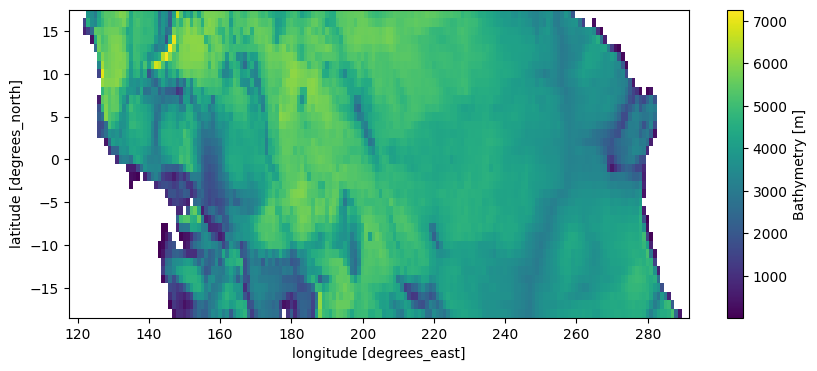

In [3]:
import matplotlib.pyplot as plt
import heapq
import numpy as np

xll,xrr = 115,295
yd,yu = -25,25
pts_l = [[121.51,yu],[143,yd]]
pts_r = [[260,yu],[290,yd]]
with xr.open_dataset(fbath) as ds:
    da = ds['deptho']
    hl = da.loc[yd:yu,xll:xrr]
    hr = da.loc[yd:yu,xll-360:xrr-360]
    hr['longitude'] = hr['longitude'] + 360
ho = xr.concat([hl,hr],dim='longitude')
col = ho.indexes['longitude'].get_indexer(list(zip(*pts_l))[0],method='nearest')
row = ho.indexes['latitude'].get_indexer(list(zip(*pts_l))[1],method='nearest')
ind_l = list(zip(row,col))
col = ho.indexes['longitude'].get_indexer(list(zip(*pts_r))[0],method='nearest')
row = ho.indexes['latitude'].get_indexer(list(zip(*pts_r))[1],method='nearest')
ind_r = list(zip(row,col))
wm = ho.values.copy()
wm+=100
wm[np.isnan(wm)] = 0
wm += 200

path_l,_ = astar_2d(wm,*ind_l)
path_r,_ = astar_2d(wm,*ind_r)

# 根据路径设置水深为np.nan
h_arr = ho.values.copy()
for r, c in path_l:
    h_arr[r, c] = np.nan
for r, c in path_r:
    h_arr[r, c] = np.nan
mask_ho = ~largest_connected_region(~np.isnan(h_arr))
ho.values[mask_ho] = np.nan
ho.values = gsmooth2d(ho.values,sigma=inc/3, norm=False)
h = ho.loc[y0:y1:inc,x0:x1:inc]
plt.figure(figsize=(10,4))
ho.plot()
plt.show()
# 可视化结果
plt.figure(figsize=(10,4))
h.plot()

h = h.values.copy()
h[np.isnan(h)] = 0
h = -h
print(ho.shape,h.shape)
writebin(opath+'bathy.bin',h)

## 基于再分析气候态数据 生成边界条件

### 分割垂向网格

In [38]:
# new vertical grid
ds = xr.open_dataset(fclim)
dep = ds['depth'].values
dr = np.zeros(dep.shape)
lev = 0
for i in range(dep.size):
    dr[i] = 2*(dep[i]-lev)
    lev += dr[i]
Rid = [0,15,20,23]+[id for id in range(25,dep.size)]
dR = np.zeros(len(Rid)-1)
for i in range(len(Rid)-1):
    dR[i] = dr[Rid[i]:Rid[i+1]].sum()
print('Nr  = {:4d}'.format(len(dR)))
print('delR='+''.join(f"{x:4.0f}," for x in dR))
print('intR='+''.join(f"{x:4.0f}," for x in dR.cumsum()))

Nr  =   28
delR=  32,  40,  48,  50,  33,  40,  48,  57,  68,  80,  94, 111, 129, 149, 171, 195, 219, 245, 270, 296, 321, 344, 366, 386, 405, 421, 435, 448,
intR=  32,  71, 119, 170, 203, 242, 290, 346, 414, 494, 588, 699, 828, 977,1148,1343,1562,1807,2077,2373,2694,3038,3404,3790,4195,4616,5051,5499,


### 生成温盐流初始场

In [5]:
ds = xr.open_dataset(fclim)

# 年平均作为初始场
# thetao = ds['thetao'].mean('time')
# so = ds['so'].mean('time')

# 一月气候态平均作为初始场
thetao = ds['thetao'][0]
so = ds['so'][0]

thetao.values[:, mask_ho] = np.nan
so.values[:, mask_ho] = np.nan

thetao.values = gsmooth2d(thetao.values,sigma=inc/3,threshold=0.1)
so.values = gsmooth2d(so.values,sigma=inc/3,threshold=0.1)

thetao = thetao.loc[:,y0:y1:inc,x0:x1:inc]
so = so.loc[:,y0:y1:inc,x0:x1:inc]
thetao, so = thetao.values, so.values
for i in range(thetao.shape[0]):
    thetao[i] = fillna(thetao[i])
    so[i] = fillna(so[i])

# 基于新的垂向网格，对温盐进行加权平均
theta = np.zeros((nz,ny,nx))
s = np.zeros((nz,ny,nx))
for i in range(nz):
    theta[i] = (thetao[Rid[i]:Rid[i+1]]*dr[Rid[i]:Rid[i+1],None,None]).sum(0)/dR[i,None,None]
    s[i] = (so[Rid[i]:Rid[i+1]]*dr[Rid[i]:Rid[i+1],None,None]).sum(0)/dR[i,None,None]
print(theta.shape, s.shape)
writebin(opath+'T.bin',theta)
writebin(opath+'S.bin',s)

(10, 36, 174) (10, 36, 174)


### 生成EXF Relax边界（SSH SSS Agrid）

(12, 36, 174)


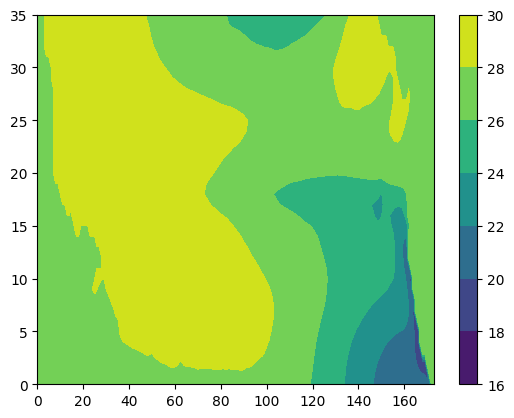

In [6]:
ds = xr.open_dataset(fclim)
thetao = ds['thetao'][:,0]
so = ds['so'][:,0]

thetao.values[:, mask_ho] = np.nan
so.values[:, mask_ho] = np.nan

thetao.values = gsmooth2d(thetao.values,sigma=inc/3,threshold=0.1,fill_value=28)
so.values = gsmooth2d(so.values,sigma=inc/3,threshold=0.1,fill_value=34)
thetao = thetao.loc[:,y0:y1:inc,x0:x1:inc]
so = so.loc[:,y0:y1:inc,x0:x1:inc]
theta, s = thetao.values, so.values
plt.contourf(theta.mean(0))
plt.colorbar()
print(theta.shape)
writebin(opath+'sst_clim.bin',theta)
writebin(opath+'sss_clim.bin',s)

### 生成侧边界条件

In [7]:
# 生成温盐流侧边界（T/S/U/V）
bd = 1
obcs = ['S','N']
varname = ['thetao','so','uo','vo']
xsi_map = {'W': slice(x0-bd, x0+bd), 'E': slice(x1-bd, x1+bd)}
ysi_map = {'S': slice(y0-bd, y0+bd), 'N': slice(y1-bd, y1+bd)}
xso_map = {'W': x0,'E': x1}
yso_map = {'S': y0,'N': y1}

ds = xr.open_dataset(fclim)
for obc in obcs:
    print(f'处理{obc}边界')
    xsi = xsi_map.get(obc, slice(None))
    ysi = ysi_map.get(obc, slice(None))
    xso = xso_map.get(obc, slice(x0,x1,inc))
    yso = yso_map.get(obc, slice(y0,y1,inc))
    for vn in varname:
        arr = ds[vn].loc[:,:,ysi,xsi].load()
        # 掩膜obs
        mask = np.isnan(ho.loc[ysi,xsi].values)
        arr.values[:,:, mask] = np.nan
        # 平滑
        arr.values = gsmooth2d(arr.values, sigma=inc/3, threshold=0.1)
        # 插值到目标网格
        arr = arr.loc[:, :, yso, xso]
        arr = arr.values
        # 填充缺失值
        for i in range(arr.shape[0]):
            for j in range(arr.shape[1]):
                arr[i,j] = fillna(arr[i,j])
        # 垂向加权平均（T/S/U/V都处理）
        arr_new = np.zeros((arr.shape[0],nz, arr.shape[2]))
        for k in range(nz):
            arr_new[:,k] = (arr[:,Rid[k]:Rid[k+1]]*dr[Rid[k]:Rid[k+1],None]).sum(1)/dR[k,None]
        print(f'{obc}_{vn[0].upper()} shape:', arr_new.shape)
        writebin(f"{opath}OB_{obc}_{vn[0].upper()}.bin", arr_new)

处理S边界
S_T shape: (12, 10, 174)
S_S shape: (12, 10, 174)
S_U shape: (12, 10, 174)
S_V shape: (12, 10, 174)
处理N边界
N_T shape: (12, 10, 174)
N_S shape: (12, 10, 174)
N_U shape: (12, 10, 174)
N_V shape: (12, 10, 174)
